In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mpl_dates
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MultipleLocator
#import featuretools as ft 
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
plt.style.use('ggplot')

warnings.simplefilter(action='ignore', category=Warning)



### <center>Introduction</center>

                                               
    The goal of this project is to analysis COVID-19 confirmed cases and apply XGBoost to train the model to predict future confirmed cases. This project was influenced by Kaggle compeition but also by various sources that provided extra datas regrading the COVID-19. I am chooising XGboost regressors as my model because I want to be comfortable with the theory behind the model (grident boosting, decision trees, regulizations and regressions).  
    

In [19]:
#github data source 

ECDC = pd.read_csv("/Users/anuragshrestha/Desktop/covid-19-data/public/data/ecdc/COVID-2019 - ECDC (2020).csv")
full_data = pd.read_csv('/Users/anuragshrestha/Desktop/covid-19-data/public/data/ecdc/full_data.csv') 
df_locations = pd.read_csv('/Users/anuragshrestha/Desktop/covid-19-data/public/data/ecdc/locations.csv')
NewCases = pd.read_csv('/Users/anuragshrestha/Desktop/covid-19-data/public/data/ecdc/new_cases.csv')
Deaths = pd.read_csv("/Users/anuragshrestha/Desktop/covid-19-data/public/data/ecdc/total_deaths.csv")

ecdc_lastest = pd.read_csv('/Users/anuragshrestha/Desktop/covid-19-data/input/ecdc/releases/latest.csv')


#kaggle Covid19 forecasting challenge data sets 

train_set = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/covid19-global-forecasting-week-3/train.csv')
test_set = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/covid19-global-forecasting-week-3/test.csv')
submission = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/covid19-global-forecasting-week-3/submission.csv')

#datasets from the community 

CountryInfo = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/covid19countryinfo.csv')
CountryTest = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/covid19tests.csv')
LocationInfo = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/locations_population.csv')
Recovered = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/novel-corona-virus-2019-dataset/covid_19_data.csv')
NewCountry = pd.read_csv('/Users/anuragshrestha/Desktop/countryinfo/population_by_country_2020.csv')
                                    


 ### <center>Exploratory data analysis</center>                                   

The highest confirmed cases in the world are the United States, Italty, and Spain. US have the highest cases per day in the world since March 28th. However, the number of fatalities per day are lower than Itatly and Spain. 

In [20]:
TopCases = train_set.groupby(['Date', 'Country_Region'])['ConfirmedCases', 'Fatalities'].sum().reset_index()
TopCases.sort_values(by = ['ConfirmedCases', 'Date'], ascending = False).head(10)


Date Country_Region  ConfirmedCases  Fatalities
12948  2020-04-02             US        243295.0      5922.0
12768  2020-04-01             US        213214.0      4753.0
12588  2020-03-31             US        188018.0      3870.0
12408  2020-03-30             US        161655.0      2975.0
12228  2020-03-29             US        140734.0      2464.0
12048  2020-03-28             US        121326.0      2023.0
12864  2020-04-02          Italy        115242.0     13915.0
12933  2020-04-02          Spain        112065.0     10348.0
12684  2020-04-01          Italy        110574.0     13155.0
12504  2020-03-31          Italy        105792.0     12428.0

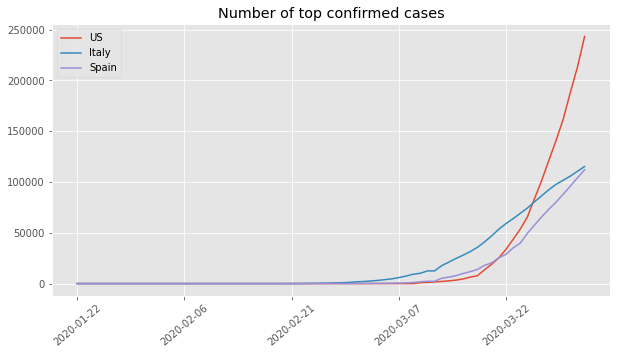

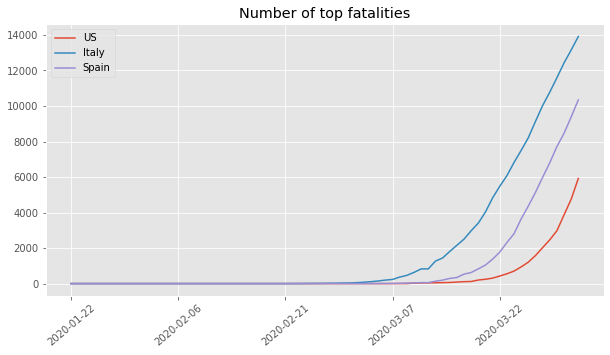

In [21]:
#top 3 countries with confirmed cases 

f, ax=plt.subplots(figsize=(10,5))

US= TopCases.loc[(TopCases['Country_Region']== 'US')]
Italy = TopCases.loc[(TopCases['Country_Region']== 'Italy')]
Spain = TopCases.loc[(TopCases['Country_Region']== 'Spain')]

plt.plot(US['Date'],US['ConfirmedCases'],linewidth=1.5,label='US')
plt.plot(Italy['Date'],Italy['ConfirmedCases'],linewidth=1.5, label = 'Italy')
plt.plot(Spain['Date'],Spain['ConfirmedCases'],linewidth=1.5, label = 'Spain')
plt.xticks(rotation=40)
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.set(title='Number of top confirmed cases')
plt.legend()
plt.show()

f, ax=plt.subplots(figsize=(10,5))

plt.plot(US['Date'],US['Fatalities'],linewidth=1.5,label='US')
plt.plot(Italy['Date'],Italy['Fatalities'],linewidth=1.5, label = 'Italy')
plt.plot(Spain['Date'],Spain['Fatalities'],linewidth=1.5, label = 'Spain')
ax.set(title='Number of top fatalities')
ax.xaxis.set_major_locator(MultipleLocator(15))
plt.xticks(rotation  = 40)
plt.legend()
plt.show()



The plot of Number of top confirmed cases and fatalities display exponentially growing trend and no signs of the   cases decreasing any time soon.

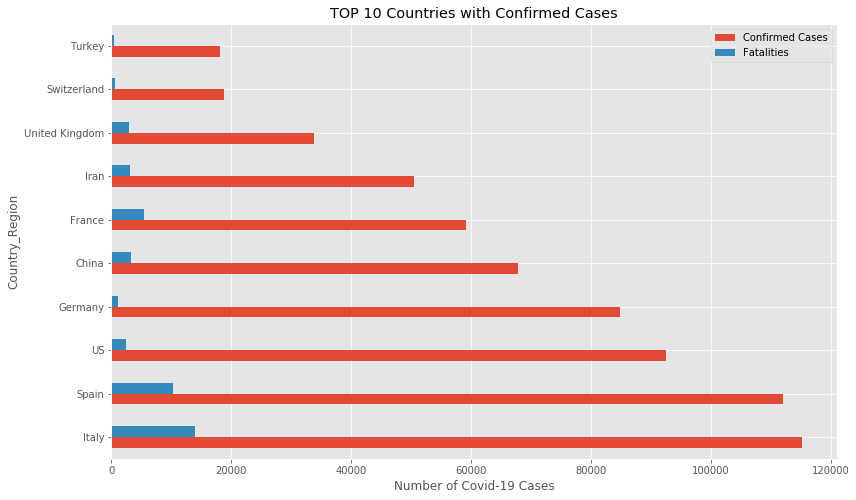

In [22]:
Max_CC = train_set.groupby(['Country_Region'],as_index=True).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
train_data_confirm = Max_CC.sort_values(by=["ConfirmedCases"], ascending=False)

train_data_confirm.head(10).plot(figsize=(13,8), kind='barh')
plt.legend(["Confirmed Cases", "Fatalities"]);
plt.xlabel("Number of Covid-19 Cases")
plt.title("TOP 10 Countries with Confirmed Cases")
plt.show()


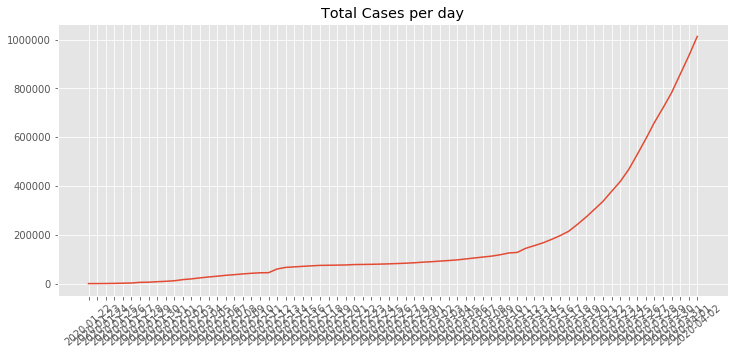

In [23]:
#total cases per day 

cases = train_set.groupby(['Date'])['ConfirmedCases'].sum()


f, ax = plt.subplots(figsize = (12,5))
plt.plot(cases)
plt.title("Total Cases per day")
plt.xticks(rotation  = 40)
plt.show()

#train_set['cases/day'] = train_set.groupby(['Date'])['ConfirmedCases'].transform('sum')

#total cases per day in the train set 



 the total cases in the world per day have the same trend as the top confirmed cases countries. 

### <center>Data Pre-processing </center>                                     

Using the dataset about the world's population and information to find valuable informations about how fast the virus can spread to each country. Also, density, urban population and density can play a role on the spread of the coronavirus

In [24]:
#adding population, density, land area, Migrants, Median Age and Urban Pop to the train set 
NewCountry = NewCountry.rename(columns= {'Country (or dependency)': 'Country', "Population (2020)": 'Population', 'Med. Age': 'Median Age'})
NewCountry['Country'] = NewCountry.Country.replace({'United States': 'US'})

#stripping the percentage 
NewCountry['Urban Pop %'] = NewCountry['Urban Pop %'].str.rstrip('%')

#changing the missing values with the mode of the column
NewCountry.loc[NewCountry['Urban Pop %']=='N.A.', 'Urban Pop %'] = int(NewCountry.loc[NewCountry['Urban Pop %']!='N.A.', 'Urban Pop %'].mode()[0])
NewCountry['Urban Pop %'] = NewCountry['Urban Pop %'].astype('int16')

# values are as percentage of the total population 
NewCountry['Urban Pop %'] = NewCountry['Urban Pop %'] / 100

#filling the missing value 
NewCountry.loc[NewCountry['Median Age']=='N.A.', 'Median Age'] = int(NewCountry.loc[NewCountry['Median Age']!='N.A.', 'Median Age'].mode()[0])
NewCountry['Median Age'] = NewCountry['Median Age'].astype('int16')

NewCountry.dtypes
NewCountry = NewCountry.drop(columns = ['World Share', 'Yearly Change', 'Net Change', 'Fert. Rate'])

#changing the NaN values on the test and train sets to 'none'
#for df in [train_set, test_set]: 
 #   df['Province_State'].fillna(value = 'None', inplace = True)

train_set = train_set.merge(NewCountry, left_on='Country_Region', right_on='Country', how='left').drop(columns = 'Country').reset_index(drop = True)
test_set = test_set.merge(NewCountry, left_on='Country_Region', right_on='Country', how='left').drop(columns = 'Country').reset_index(drop = True)

train_set['Date'] = pd.to_datetime(train_set['Date'], format = '%Y-%m-%d')
test_set['Date'] = pd.to_datetime(test_set['Date'], format = '%Y-%m-%d')


In [25]:
#getting days, months, and years
def dayMonth(df):
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day  
    return df


def Percentage(df): 
    df['%CasesinPop'] = df['ConfirmedCases'] / df['Population']#% of population with corona cases
    df['%FatalitiesinPop'] = df['Fatalities'] / df['Population'] 
    
    return df 

Percentage(train_set)

for df in [train_set, test_set]: 
    dayMonth(df)
    
train_set

Id Province_State Country_Region       Date  ConfirmedCases  \
0          1            NaN    Afghanistan 2020-01-22             0.0   
1          2            NaN    Afghanistan 2020-01-23             0.0   
2          3            NaN    Afghanistan 2020-01-24             0.0   
3          4            NaN    Afghanistan 2020-01-25             0.0   
4          5            NaN    Afghanistan 2020-01-26             0.0   
...      ...            ...            ...        ...             ...   
22027  32703            NaN       Zimbabwe 2020-03-29             7.0   
22028  32704            NaN       Zimbabwe 2020-03-30             7.0   
22029  32705            NaN       Zimbabwe 2020-03-31             8.0   
22030  32706            NaN       Zimbabwe 2020-04-01             8.0   
22031  32707            NaN       Zimbabwe 2020-04-02             9.0   

       Fatalities  Population  Density (P/Km²)  Land Area (Km²)  \
0             0.0  38928346.0             60.0         652860.0   
1             0.0  38928346.0             60.0         652860.0   
2             0.0  38928346.0             60.0         652860.0   
3             0.0  38928346.0             60.0         652860.0   
4             0.0  38928346.0             60.0         652860.0   
...           ...         ...              ...              ...   
22027         1.0  14862924.0             38.0         386850.0   
22028         1.0  14862924.0             38.0         386850.0   
22029         1.0  14862924.0             38.0         386850.0   
22030         1.0  14862924.0             38.0         386850.0   
22031         1.0  14862924.0             38.0         386850.0   

       Migrants (net)  Median Age  Urban Pop %   %CasesinPop  \
0            -62920.0        18.0         0.25  0.000000e+00   
1            -62920.0        18.0         0.25  0.000000e+00   
2            -62920.0        18.0         0.25  0.000000e+00   
3            -62920.0        18.0         0.25  0.000000e+00   
4            -62920.0        18.0         0.25  0.000000e+00   
...               ...         ...          ...           ...   
22027       -116858.0        19.0         0.38  4.709706e-07   
22028       -116858.0        19.0         0.38  4.709706e-07   
22029       -116858.0        19.0         0.38  5.382521e-07   
22030       -116858.0        19.0         0.38  5.382521e-07   
22031       -116858.0        19.0         0.38  6.055336e-07   

       %FatalitiesinPop  Month  Day  
0          0.000000e+00      1   22  
1          0.000000e+00      1   23  
2          0.000000e+00      1   24  
3          0.000000e+00      1   25  
4          0.000000e+00      1   26  
...                 ...    ...  ...  
22027      6.728151e-08      3   29  
22028      6.728151e-08      3   30  
22029      6.728151e-08      3   31  
22030      6.728151e-08      4    1  
22031      6.728151e-08      4    2  

[22032 rows x 16 columns]

In [26]:
#preparing features such as lags, growth rate of cases and fatalities, and rate difference 

#adding lags on the training set to find the growth of the cases and fatalities during the time 

lag = range(1,10,1)
col= ['Confirmed_Cases', 'Fatalities']

for lag in range(1,10):
    train_set[f"CC_{lag}_lag"] = train_set["ConfirmedCases"].shift(lag).fillna(0)
    train_set[f"Fatal_{lag}_lag"] = train_set["Fatalities"].shift(lag).fillna(0)
    


#days since 1, 50,100, 1000 cases 

days_since_cases = [1,50,100,1000]

for case in days_since_cases: 
    train_set = train_set.merge(train_set[train_set.ConfirmedCases >= case].groupby("Country_Region")["Date"].min().
                              reset_index().rename(columns = {"Date": f"case_{case}_date"}), on = "Country_Region", how = "left")

#drop the duplicates 





In [27]:
#feature def functions 


In [28]:

#encoding the country and states into numerical values 
#replacing the missing province state with just country name for now 

def encoder(df): 
    df.Province_State.fillna(value = 'None', inplace = True)
    label_maker = OrdinalEncoder()
    df[['Province_State','Country_Region']] = label_maker.fit_transform(df.loc[:,['Province_State','Country_Region']])
    #df.loc[:, 'Date'] = df['Date'].dt.strftime("%m%d")
    #df['Date'] = df['Date'].astype('int')
    return df 

for df in [train_set, test_set]:
    encoder(df)
    


### <center>Model</center>      

In [29]:
#features for now 

target1 = ['ConfirmedCases']
target2 = ['Fatalalities']

features_Cases = ['Month', 
                  'Day',  #not using days at all 
                  'Population', 
                 # 'Country_Region',
                 # 'Province_State',
                  #'Density (P/Km²)' 
                  #,'Land Area (Km²)', 
                  #'Migrants (net)',
                 # 'Median Age',
                 # 'Urban Pop',
                   "%CasesinPop",
                  'ConfirmedCases1', 
                  "ConfirmedCases2", 
                  'ConfirmedCases3',
                  'ConfirmedCases4',
                  'ConfirmedCases5', 'ConfirmedCases6']
        
parameters = {'learning_rate': .07, 
                      'max_depth': 2,
                      'min_child_weight': 5,
                      'colsample_bytree': .5,
                      'reg_alpha': 1,
                      'reg_lambda': 4,
                      'n_estimators': 1000}






In [30]:
for country in train_set['Country_Region'].unique(): 
    xtrain1 = train_set[train_set['Country_Region'] == country]
    
    for state in xtrain1.Province_State.unique(): 
        xtrain2 = xtrain1[xtrain1['Province_State'] == state]
        
        Train_set = xtrain2[xtrain2['Date'] < '2020-03-02']
        valid_set = xtrain2[(xtrain2['Date'] >= '2020-03-02') & (xtrain2['Date'] < '2020-03-26')] 
        Test_set = xtrain2[xtrain2['Date'] >= '2020-03-26']
        
        X_train = train_set[features_Cases].values
        X_valid = valid_set[features_Cases].values
        X_test = Test_set[features_Cases].values

        y_train = np.log(train_set[target1].values.clip(0, 1e10)+1)
        y_val = np.log(valid_set[target1].values.clip(0, 1e10)+1)
        x_test = np.log(Test_set[target1].values.clip(0,1e10)+1)
        

        
        model = xgb.XGBRFRegressor(**parameters,objective ='reg:squarederror')


#find the parameters through grid search? 


#xgb_grid = GridSearchCV(xgb,parameters, cv = 2, n_jobs = 2, verbose=True)

#xgb_grid.fit(X_train, y_train)

#print(xgb_grid.best_score_) #0.9794510916798058 0.979984356266905 
#print(xgb_grid.best_params_)

#{'colsample_bytree': 0.5, 
#'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 1000, 'reg_alpha': 2, 'reg_lambda': 1}

        model.fit(X_train,y_train, eval_metric = 'rmse', eval_set = [(X_train, y_train),(X_valid, y_val)], early_stopping_rounds = 5, verbose=True)

KeyError: "['ConfirmedCases6', 'ConfirmedCases5', 'ConfirmedCases1', 'ConfirmedCases3', 'ConfirmedCases2', 'ConfirmedCases4'] not in index"

In [ ]:
joblib.dump(model, 'xgb.joblib.dat')

In [ ]:
#graph of feature importance 

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Features Importance")
plt.show()


#results of validation 
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
epochs
#fig, ax = plt.subplots(figsize = (15,10))
#x_axis = range(epochs)
#ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
#ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
#ax.legend()
#plt.ylabel("RMSE")
#plt.show()

 

In [ ]:
score = model.get_booster().get_fscore()

score = pd.Series(score, name='featureScore')
score.index.name = 'Feature'
score = score.reset_index()
score = pd.DataFrame(score)
score = score.sort_values(by = ['featureScore'], ascending = True)
score 
            

In [ ]:


#to predict the model 
        
#XGB_2 = XGB_1
#XGB_2.fit(x_train, y_train2, eval_metric="rmse",eval_set=[(x_train, y_train), (x_cv, y_cv2)] )    #for fatalities 
        
       # xtest1 = test_set[(test_set['Country_Region'] == country) & (test_set['Province_State'] == state)]
        #ForeCastID = xtest1.Id.values 
        
        # xtest2 = xtest1[features_test].values
        
       # predictions of 2 output in the matrix
        #cases_pred = np.round(XGB_1.predict(xtest2),5)
        #death_pred = np.round(XGB_2.predict(xtest2),5)
        
        #Append the predicted values to submission list
       # for i in range(len(cases_pred)):
        #    d = {'ForecastId': ForeCastID[i], 'ConfirmedCases': cases_pred[i], 'Fatalities':death_pred[i]}
         #   prediction.append(d)
    

In [ ]:
#submission = pd.DataFrame(prediction)

#submission.to_csv('BasePrediction.csv', index = False)